# Posture Detection Model

## 1 Engineer features

### 1.1 Import libraries and define transformers  

In [1]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import make_pipeline, make_union
from keras.utils import to_categorical
from __future__ import print_function
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.api.types import is_numeric_dtype
import warnings
warnings.filterwarnings("ignore")
import ipytest.magics
import pytest
__file__ = 'drone_pos_model_christian.ipynb'

Using TensorFlow backend.


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import os
os.getcwd()

'C:\\Users\\Christian\\git\\drone_steering\\models'

In [4]:
os.chdir('..')

In [5]:
from app.module import Shuffler, XCentralizer, YCentralizer, YScaler

### 1.2  Inspect data

In [6]:
df = pd.read_csv("data/posture/posture_training_data.csv",low_memory=False)
df = df.dropna().drop_duplicates()
print(df.shape)
df.head()

(1867, 13)


,leftShoulder_x,leftShoulder_y,rightShoulder_x,rightShoulder_y,leftWrist_x,leftWrist_y,rightWrist_x,rightWrist_y,leftHip_x,leftHip_y,rightHip_x,rightHip_y,label
0,364.388477,175.727292,326.376146,176.318343,373.932203,185.283770,323.401138,178.613052,363.882516,247.058341,335.419796,245.791503,3
9,362.043733,162.669425,322.806684,162.934143,368.892477,106.262375,314.567677,103.431298,360.476755,244.545429,332.341002,246.078227,1
10,361.398062,161.761029,319.718081,157.452745,359.997208,94.588426,315.145723,95.310308,358.496267,245.388146,332.033283,245.604833,1
11,356.940976,156.356530,317.715580,160.940937,355.271911,92.585746,315.198539,95.782529,355.675736,241.225170,332.092374,243.839404,1
12,355.355181,159.860870,319.357292,159.059428,355.228806,95.781997,315.496033,96.264859,355.045702,243.383177,330.646016,244.469512,1


In [7]:
assert df.isnull().all().all() == False

### 1.3 Set pipeline arguments

In [8]:
x_cols = ['leftShoulder_x', 'rightShoulder_x', 'leftWrist_x', 'rightWrist_x', 'leftHip_x' ,'rightHip_x']
y_cols = list(set(df.columns)-set(x_cols))

### 1.4 Build data processing pipeline

In [9]:
processing_pipeline = make_pipeline(XCentralizer(x_cols), YCentralizer(y_cols), YScaler(), Shuffler())
processed_df = processing_pipeline.fit_transform(df)
processed_df.head()

,leftShoulder_x,leftShoulder_y,rightShoulder_x,rightShoulder_y,leftWrist_x,leftWrist_y,rightWrist_x,rightWrist_y,leftHip_x,leftHip_y,rightHip_x,rightHip_y,label
307,0.269966,-0.504198,-0.269966,-0.495802,0.405526,-0.368456,-0.312223,-0.463208,0.262779,0.508997,-0.141509,0.491003,3
1048,0.237771,-0.501604,-0.237771,-0.498396,0.320776,-1.185243,-0.337626,-1.219555,0.218780,0.490711,-0.122218,0.509289,1
111,0.242637,-0.474920,-0.242637,-0.525080,0.226327,-1.257000,-0.295872,-1.248596,0.208852,0.498739,-0.099253,0.501261,1
195,0.233809,-0.527326,-0.233809,-0.472674,0.213911,-1.287556,-0.263815,-1.249446,0.218725,0.484417,-0.062419,0.515583,1
176,0.213091,-0.495256,-0.213091,-0.504744,0.211594,-1.253889,-0.258804,-1.248173,0.209427,0.493569,-0.079443,0.506431,1


In [10]:
assert df.shape[0] == processed_df.shape[0]

## 2 Train model

### 2.1  Split in train / test

In [11]:
df_train = processed_df.iloc[:int(processed_df.shape[0]*0.8)]
df_test = processed_df.iloc[int(processed_df.shape[0]*0.8):]

In [12]:
assert df_train.shape[0] + df_test.shape[0] == df.shape[0]

### 2.2 Define numpy arrays as needed by model

In [13]:
x_train = df_train.drop(['label'], axis=1).values
y_train = df_train['label'].values

x_test = df_test.drop(['label'], axis=1).values
y_test = df_test['label'].values

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [14]:
print(x_train.shape, y_train.shape )
print("x_train[0]=", x_train[0],"\n y_train[0]=", y_train[0])

(1493, 12) (1493, 7)
x_train[0]= [ 0.26996587 -0.50419768 -0.26996587 -0.49580232  0.40552611 -0.36845632
 -0.31222324 -0.463208    0.26277915  0.50899717 -0.14150876  0.49100283] 
 y_train[0]= [0. 0. 0. 1. 0. 0. 0.]


### 2.3 Define and compile model

In [15]:
from keras import models, layers
from keras.models import Model
from keras.layers import Input, Dense
from keras import optimizers, losses, metrics

model = models.Sequential()
model.add(layers.Dense(20, activation="relu", input_shape=(12, )))
model.add(layers.Dense(15, activation="relu"))
model.add(layers.Dense(7, activation="softmax")) 
model.summary()   

model.compile(optimizer=optimizers.RMSprop(lr=0.005),
              loss=losses.categorical_crossentropy,
              metrics=["accuracy"])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 20)                260       
_________________________________________________________________
dense_2 (Dense)              (None, 15)                315       
_________________________________________________________________
dense_3 (Dense)              (None, 7)                 112       
Total params: 687
Trainable params: 687
Non-trainable params: 0
_________________________________________________________________


### 2.4 Fit and validate model

In [16]:
history = model.fit(x_train, y_train, epochs=30, batch_size=30, validation_split=0.2)

Train on 1194 samples, validate on 299 samples
Epoch 1/30
1194/1194 [==============================] - 0s 293us/step - loss: 0.9176 - acc: 0.7479 - val_loss: 0.4001 - val_acc: 0.9866
Epoch 2/30
1194/1194 [==============================] - 0s 84us/step - loss: 0.1724 - acc: 0.9966 - val_loss: 0.0840 - val_acc: 0.9933
Epoch 3/30
1194/1194 [==============================] - 0s 91us/step - loss: 0.0324 - acc: 0.9992 - val_loss: 0.0244 - val_acc: 0.9933
Epoch 4/30
1194/1194 [==============================] - 0s 85us/step - loss: 0.0085 - acc: 0.9992 - val_loss: 0.0095 - val_acc: 1.0000
Epoch 5/30
1194/1194 [==============================] - 0s 126us/step - loss: 0.0044 - acc: 0.9983 - val_loss: 0.0049 - val_acc: 1.0000
Epoch 6/30
1194/1194 [==============================] - 0s 121us/step - loss: 0.0028 - acc: 0.9992 - val_loss: 0.0048 - val_acc: 1.0000
Epoch 7/30
1194/1194 [==============================] - 0s 103us/step - loss: 0.0026 - acc: 0.9992 - val_loss: 0.0029 - val_acc: 1.0000
Epoc

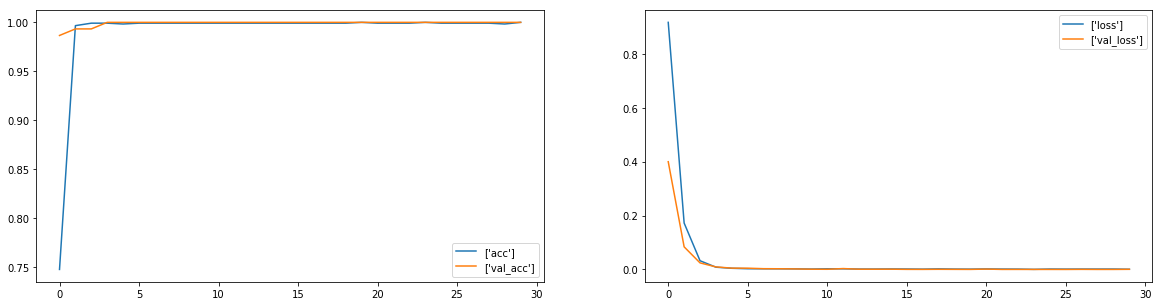

In [17]:
plt.figure(figsize=(20, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history["acc"],  label=["acc"])
plt.plot(history.history['val_acc'], label=["val_acc"])
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label=["loss"]) 
plt.plot(history.history['val_loss'], label=["val_loss"])
plt.legend()

plt.show()
plt.close()

###  2.5 Evaluate with test data

In [18]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print("Loss / Accuracy Evaluation")
print("--------------------------")
print("Loss:     " + str(round(test_loss,5)))
print("Accuracy: " + str(round(test_acc,5)))

374/374 [==============================] - 0s 32us/step
Loss / Accuracy Evaluation
--------------------------
Loss:     0.00042
Accuracy: 1.0


In [19]:
y_tes_pred = model.predict(x_test)

In [20]:
y_tes_pred[10]

array([2.6834255e-16, 9.9999976e-01, 1.2831334e-12, 2.0140693e-07,
       5.2358971e-19, 9.9192987e-24, 2.8749407e-26], dtype=float32)

In [21]:
y_test[10]

array([0., 1., 0., 0., 0., 0., 0.], dtype=float32)

### 2.6 Save model

#### 2.6.1 h5 format

In [22]:
from keras.models import load_model
import h5py

In [23]:
# save model, delete current reference and re-load it from file
model.save('models/model_posture.h5')
del model
model = load_model('models/model_posture.h5')

In [24]:
type(model)

keras.engine.sequential.Sequential

#### 2.6.2 tensorflow.js format (JSON)

The tensorflowjs library can't be installed directly with pip / conda due to conflicting dependencies. Best is to set up a new environment explicitly for this and install tensorflowjs with the following commands:

```
pip install tensorflow==1.11.0rc2 h5py numpy keras
pip install --no-deps tensorflowjs
```

In [25]:
# ! pip install tensorflow==1.11.0rc2 h5py numpy keras
# ! pip install --no-deps tensorflowjs
# ! pip install ipykernel
# ! pip install tensorflow_hub
# import tensorflowjs as tfjs

In [26]:
# tfjs.converters.save_keras_model(model, 'model_json')

We need to adapt the two files as follows in order for them to work on Azure:
* add a file extension .pb to the file with no extension (otherwise Azure blocks it from viewing)
* adapt the automatically generated model.json to reflect the extension .pb